# import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, "../../code-previous")

In [4]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator


import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [5]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [6]:
discipline = "Astronomy & Astrophysics"

In [7]:
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [8]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words
1212,1212,Astronomy & Astrophysics,1900,"[crossley reflector lick obsertvatory, crossle...","[calculation elliptic elements system cygni , ...",calculation elliptic elements system cygni ph...,calculation elliptic elements system cygni phy...
1213,1213,Astronomy & Astrophysics,1901,"[accuracy photographic measures second note ,...","[form interferometer , sixty four variable sta...",form interferometer sixty four variable stars...,form interferometer sixty four variable stars ...
1214,1214,Astronomy & Astrophysics,1902,"[miscellaneous results , miscellaneous results...",[researches spectra metals spectrum molybdenu...,researches spectra metals spectrum molybdenum...,researches spectra metals spectrum molybdenum ...
1215,1215,Astronomy & Astrophysics,1903,"[cape double star results 1903 , cape double ...",[spectrographic observations standard velocity...,spectrographic observations standard velocity ...,spectrographic observations standard velocity ...
1216,1216,Astronomy & Astrophysics,1904,[magnetic disturbances recorded royal observat...,"[ninth satellite saturn , revised elements cyg...",ninth satellite saturn revised elements cygni...,ninth satellite saturn revised elements cygni ...


In [9]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

In [10]:
count_vocab = {value:key for key,value in vectorizer.vocabulary_.items()}
count_rev_dict = {value:key for key,value in vectorizer.vocabulary_.items()}
words = [count_rev_dict[i] for i in range(len(vectorizer.vocabulary_.keys()))]

In [11]:
vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [12]:
vectorized_wordarray.shape

(117, 47379)

In [13]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:00<00:00, 391.43it/s]


In [14]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

__Frequency Variations:__ Words which have a frequency of 20 in year Y<sub>t</sub>. How much do they normally vary in years Y<sub>t+1</sub>, t<sub>t+2</sub> etc. 

In [15]:
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
#         if index == 49 and uniq == 12:
#             import ipdb
#             ipdb.set_trace()
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 116/116 [00:00<00:00, 186.27it/s]


In [16]:
len(yearly_word_frequency_variations)

116

__Word Frequency Variations Plot | Year__

__Year:__ 2011

No handles with labels found to put in legend.


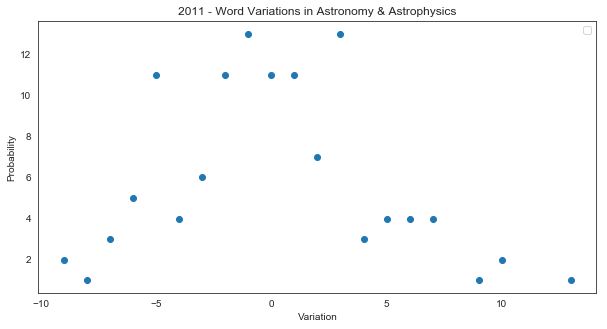

In [17]:
year = 2011

N = 110
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]


from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [y for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

In [25]:
len(freq50)

47379

No handles with labels found to put in legend.


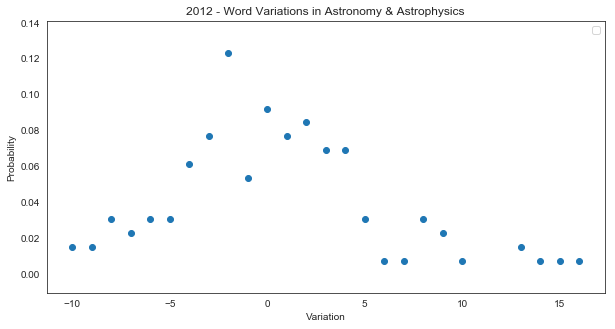

In [31]:
year = 2012

N = 111
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

In [29]:
counts_ = dict(Counter(variations)).values()
counts_

dict_values([12, 15, 9, 1, 6, 10, 13, 3, 8, 9, 8, 2, 5, 2, 1, 11, 7, 3, 5, 2, 2, 1, 1, 1])

In [27]:
len(indices)

137

No handles with labels found to put in legend.


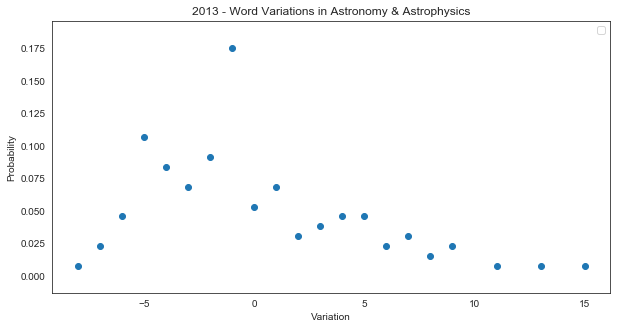

In [32]:
year = 2013

N = 112
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  


f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


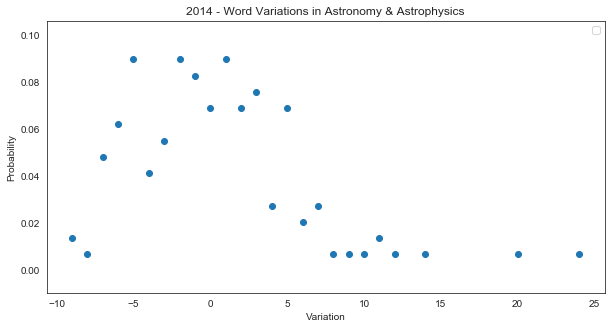

In [33]:
year = 2014

N = 113
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]


variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


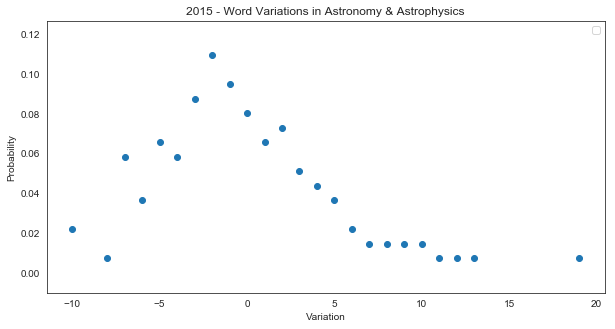

In [34]:
year = 2015

N = 114
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()